# GAM-based Pseudotime Testing

The goal of this module is to identify genes whose expression changes significantly along pseudotime.  
We fit **Negative Binomial Generalized Additive Models (NB-GAMs)** to single-cell data and perform  
statistical tests on the smooth terms. This allows us to detect dynamic genes while accounting for  
overdispersion, smoothing, and model uncertainty.


## Load libraries

In [24]:
import gamache as gm
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [2]:
adata = sc.datasets.paul15()

In [3]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()

## Preprocessing

In [4]:
sc.pp.recipe_zheng17(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(


In [5]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


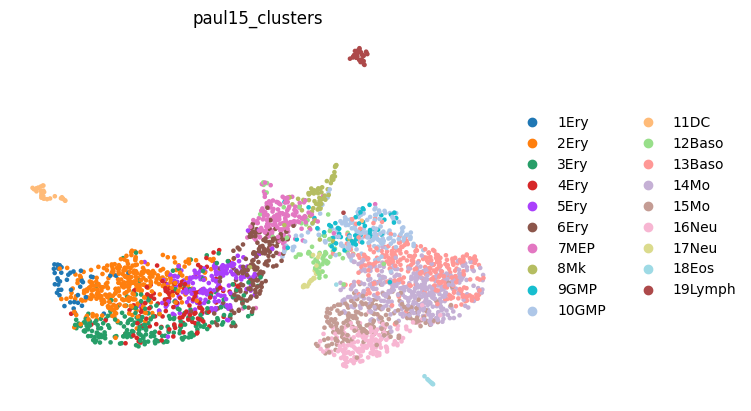

In [6]:
sc.pl.umap(adata, color=["paul15_clusters"], frameon=False)

In [7]:
# Subset to [1Ery, 2Ery, 3Ery, 4Ery, 5Ery, 6Ery, 7MEP, 8Mk]
adata = adata[
    adata.obs["paul15_clusters"].isin(
        ["1Ery", "2Ery", "3Ery", "4Ery", "5Ery", "6Ery", "7MEP", "8Mk"]
    ),
    :,
]

In [8]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


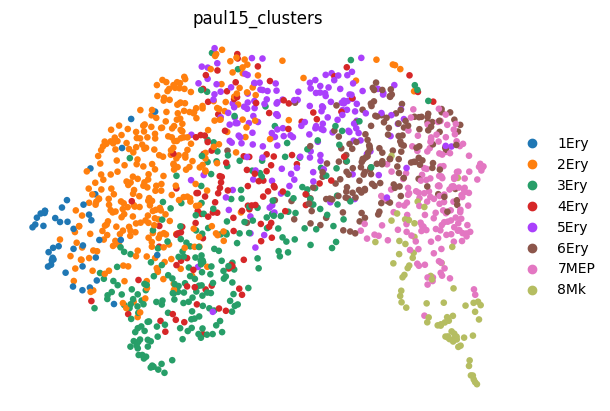

In [9]:
sc.pl.umap(adata, color=["paul15_clusters"], frameon=False)

In [10]:
sc.tl.diffmap(adata)

In [11]:
DC1 = [first[0] for first in adata.obsm["X_diffmap"]]
DC2 = [first[1] for first in adata.obsm["X_diffmap"]]
DC_tmp = [first[0] + first[1] for first in adata.obsm["X_diffmap"]]

adata.uns["iroot"] = np.argsort(DC_tmp)[-1]

sc.tl.dpt(adata)

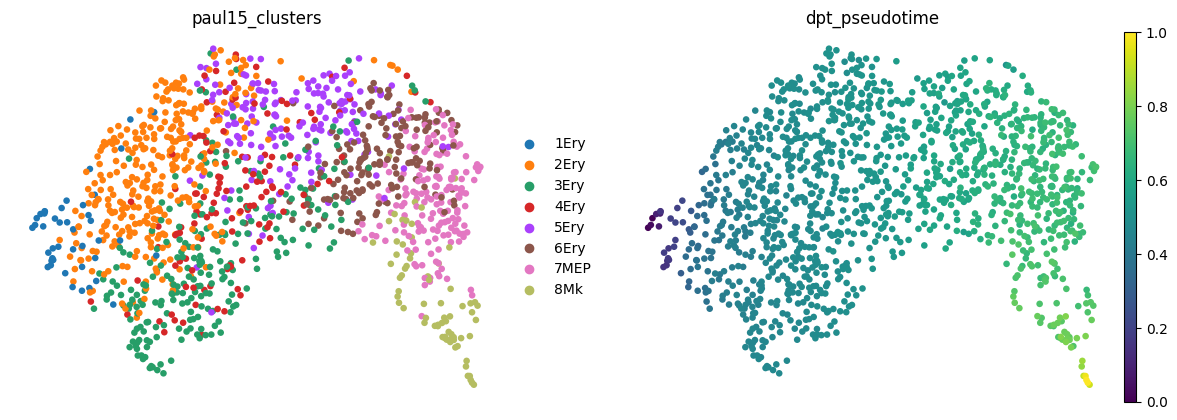

In [12]:
sc.pl.umap(adata, color=["paul15_clusters", "dpt_pseudotime"], frameon=False)

In [13]:
adata.write("paul15_endo.h5ad")

## Remove lowly expressed genes

In [ ]:
adata = sc.read("paul15_endo.h5ad")

# adata.X must contain raw counts for GAM fitting
adata = adata.raw.to_adata()

In [19]:
sc.pp.filter_genes(adata, min_cells=50)

## Fit the GAM model

We now fit a **Generalized Additive Model (GAM)** to the data.  
The hyperparameters can be tuned to improve the fit:

- **`lam`**: Regularization parameter that controls the amount of smoothing.  
  - Higher `lam` → smoother curve (less flexible).  
  - Lower `lam` → more flexible curve (risk of overfitting).

- **`df`**: Degrees of freedom, i.e. the number of basis functions.  
  - Higher `df` → more flexible fit.  
  - Lower `df` → smoother fit.

The choice of `lam` and `df` depends on the data and the desired balance between smoothness and flexibility.  
As a starting point, we use:

- `lam = 1`  
- `df = 8`

You are encouraged to experiment with different values to observe how they affect the resulting fit.


In [20]:
model = gm.tl.fit_gam(adata, lam=1, df=8)

## Assess Goodness of Fit

To measure how well the NB-GAM describes expression dynamics along pseudotime,  
we use the **proportion of deviance explained**.

- The **null model** assumes constant expression (a flat curve).  
- The **fitted model** explains variation by smoothing expression along pseudotime.  
- The metric is defined as:

$$D_{explained} = 1 - \frac{Deviance_{residual}}{Deviance_{null}}$$

Values range between 0 and 1:
- **0** → no improvement over the null model.  
- **1** → perfect fit to the data.  

If the deviance explained is **slightly negative**, it means the model fit is worse than the null, usually due to numerical noise or lack of signal.  
In practice, such values are often set to **0** and interpreted as “no improvement”.

In [21]:
# Get the deviance explained
gof_df = model.deviance_explained()

/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:339: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = self.adata.var[self.key + "_alpha"][gene]
/Users/adaml9/Code/github/gamache/src/gamache/tl/utils.py:132: RuntimeWarning: divide by zero encountered in log
  term1 = np.where(y > 0, y * np.log(y / mu), 0.0)
/Users/adaml9/Code/github/gamache/src/gamache/tl/utils.py:132: RuntimeWarning: invalid value encountered in multiply
  term1 = np.where(y > 0, y * np.log(y / mu), 0.0)


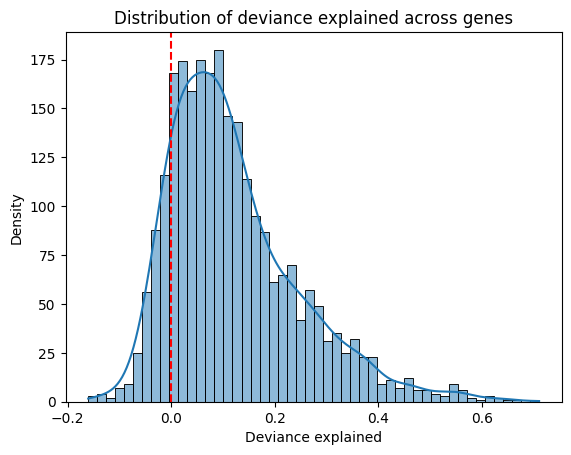

In [25]:
# Plot as a histogram
sns.histplot(gof_df, bins=50, kde=True)

plt.xlabel("Deviance explained")
plt.ylabel("Density")
plt.title("Distribution of deviance explained across genes")
plt.axvline(0, color="red", linestyle="--", label="Median")
plt.show()

In [ ]:
# Restrict to genes above zero
gof_df = gof_df[gof_df > 0]

## Test for association with pseudotime

In [84]:
# Test all genes for association with pseudotime
results_df = model.test_all(test="association")

# Filter results for q-value < 0.05
# Note: P-values are not uniformly distributed (yet), so q-values are not reliable.
results_df = results_df[results_df["qvalue"] < 0.05]

# Set gene as index
results_df = results_df.set_index("gene")

# Take top 10 genes with highest mean_fitted
top_genes = results_df.nlargest(10, "mean_fitted")
top_genes = top_genes.index.tolist()

/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:481: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.adata.var[self.key + "_alpha"][


(<Figure size 913x480 with 1 Axes>,
 <Axes: title={'center': 'Fit for Car2'}, xlabel='Pseudotime', ylabel='Expression Car2'>)

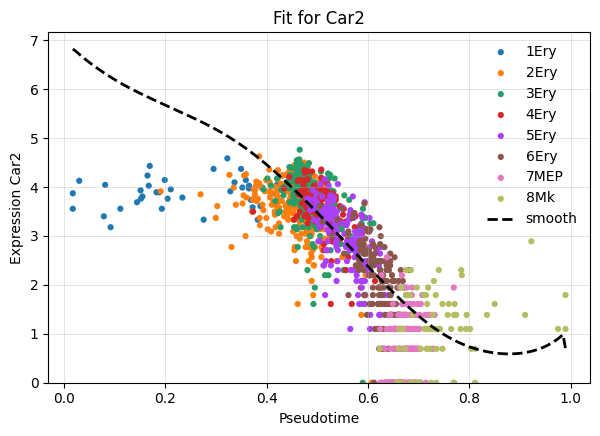

In [85]:
gm.pl.plot_gene_fit(model, top_genes[0], color="paul15_clusters", scatter_size=80)

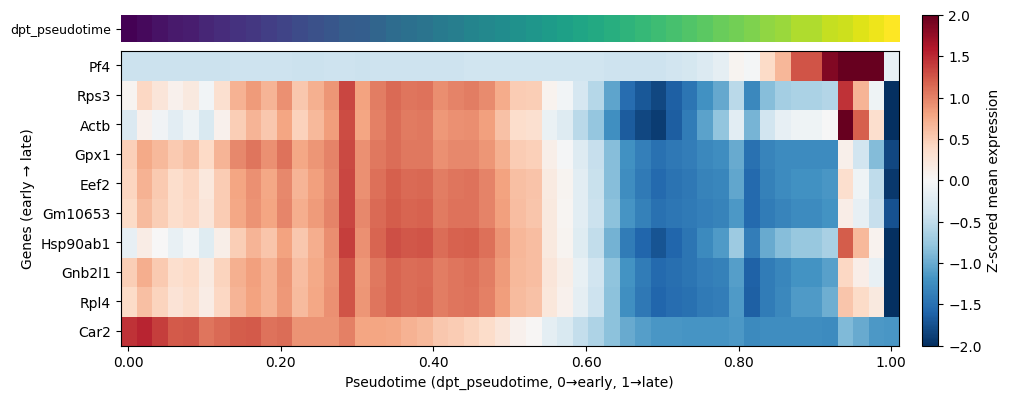

(['Car2',
  'Rpl4',
  'Gnb2l1',
  'Hsp90ab1',
  'Gm10653',
  'Eef2',
  'Gpx1',
  'Actb',
  'Rps3',
  'Pf4'],
 array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
        0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
        0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
        0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
        0.89, 0.91, 0.93, 0.95, 0.97, 0.99]),
 array([[ 1.4379687198e+00,  1.5267470699e+00,  1.3773235777e+00,
          1.2279000855e+00,  1.2407736147e+00,  1.0630368752e+00,
          1.1380993548e+00,  1.2131618344e+00,  1.2212323898e+00,
          1.0787736080e+00,  1.1145375978e+00,  8.9869694451e-01,
          9.0204460597e-01,  9.0539226743e-01,  1.0011270220e+00,
          7.9336694519e-01,  7.9164737001e-01,  7.6609391203e-01,
          6.9415996878e-01,  6.5298624818e-01,  5.3211437814e-01,
          5.0827610128e-01,  4.5278842403e-01,  3.6830308513e-01,
          2.388295286

In [86]:
gm.pl.plot_gene_heatmap(adata, top_genes, cmap="RdBu_r", model=model)